In [1]:
#!/usr/bin/env python
# coding: utf-8
from sqlalchemy import create_engine
import sys
import platform
import logging
import trino
import matplotlib.pyplot as plt 
sys.path.append('..')
from common import db_operations

import trino
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from common.db_operations import connect_to_trino, fetch_data_for_day, write_df_to_iceberg

from math import radians, sin, cos, sqrt, atan2

In [2]:
def get_battery_data(start_time=None, end_time=None, vehicle_ids=None):
    """
    Fetch battery data from Trino with flexible time filtering.
    
    Args:
        start_time: Start time in 'YYYY-MM-DD HH:MM:SS' format (optional)
        end_time: End time in 'YYYY-MM-DD HH:MM:SS' format (optional)
        vehicle_ids: List of vehicle IDs to filter (optional)
    
    Returns:
        DataFrame with battery data
    """
    # Set default vehicle IDs if not provided
    if vehicle_ids is None:
        vehicle_ids = ['3','6','7','9','11','12','13','14','15','16', '18','19','27','28','29']
    
    # Format vehicle IDs for the query
    vehicle_ids_str = "', '".join(vehicle_ids)
    
    # Build time filter conditions
    time_filter_cpo100 = ""
    time_filter_can_ac = ""
    
    if start_time and end_time:
        # Convert string times to datetime objects
        start_dt = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
        end_dt = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
        
        # Format for the query
        time_filter_cpo100 = f"""
        AND timestamp >= CAST('{start_time}' AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata'
        AND timestamp < CAST('{end_time}' AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata'
        """
        
        time_filter_can_ac = f"""
        AND timestamp >= CAST('{start_time}' AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata'
        AND timestamp < CAST('{end_time}' AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata'
        """
    
    # Build the complete query
    query = f"""
    with cpo100 as
    (
      SELECT 
        id, CAST(timestamp AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata' as timestamp, dt, 
        date_trunc('minute', CAST(timestamp AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata') as ts_mins,
        batterycoolingstate, batterycoolanttemperature,
        temperaturedifferencealarm, chargingcurrentalarm, dischargecurrentalarm,
        vehiclereadycondition, gun_connection_status, ignitionstatus,
        pack1_cellmax_temperature, pack1_maxtemperature_cell_number,
        pack1_cell_min_temperature, pack1_celltemperature_cellnumber
      from 
        facts_prod.can_parsed_output_100
      where 
        id IN ('{vehicle_ids_str}')
        {time_filter_cpo100}
    ),
    cpo100_ranked as
    (
      select 
        *, row_number() over(partition by id, ts_mins order by timestamp) as cpo_rn
      from 
        cpo100
    ),
    can_ac as
    (
      select 
        id, CAST(timestamp AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata' as timestamp, date,
        date_trunc('minute', CAST(timestamp AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata') as ts_mins_cac,    
        b2t_tms_control_cmd, b2t_set_water_out_temp, b2t_battery_min_temp, b2t_battery_max_temp,
        tms_working_mode, tms_fault_code, coolant_out_temp, coolant_in_temp,
        (coolant_out_temp - coolant_in_temp) as coolant_temp_diff,
        comp_target_hz as comp_target_freq,
        comp_running_frequency as comp_running_freq,
        comp_status, v2t_vehicle_coolant_low, comp_current
      from 
        facts_prod.can_output_ac
      where
        id IN ('{vehicle_ids_str}')
        and b2t_battery_min_temp != -40
        and coolant_in_temp != 0
        {time_filter_can_ac}
    ),
    can_ac_ranked as
    (
      select 
        *, row_number() over(partition by id, ts_mins_cac order by timestamp) as cac_rn
      from can_ac
    )
    select 
        cp.id, dt, cp.timestamp, cp.ts_mins, batterycoolingstate, batterycoolanttemperature,
        ignitionstatus, vehiclereadycondition, gun_connection_status,
        pack1_cellmax_temperature, pack1_cell_min_temperature,
        b2t_tms_control_cmd, b2t_set_water_out_temp,
        b2t_battery_min_temp, b2t_battery_max_temp, tms_working_mode,
        coolant_out_temp, coolant_in_temp, coolant_temp_diff, tms_fault_code
    from 
      cpo100_ranked as cp
      right join
      can_ac_ranked as cn
      on (cp.id = cn.id and cp.ts_mins = cn.ts_mins_cac and cp.cpo_rn = cn.cac_rn)
    ORDER BY cp.id, cp.timestamp
    """
    
    # Connect to Trino
    conn = trino.dbapi.connect(
        host="trino",
        port=8080,
        user="admin",
        catalog="adhoc",
        schema="default"
    )
    
    # Execute the query
    cur = conn.cursor()
    cur.execute(query)
    
    # Get column names
    columns = [desc[0] for desc in cur.description]
    
    # Fetch all rows
    rows = cur.fetchall()
    
    # Create DataFrame
    df = pd.DataFrame(rows, columns=columns)
    
    # Close connections
    cur.close()
    conn.close()
    
    return df

In [3]:
#Funtion to get data for one last one hour
def get_recent_battery_data(hours=1, vehicle_ids=None):
    """
    Get battery data for the last N hours.
    
    Args:
        hours: Number of hours to look back
        vehicle_ids: List of vehicle IDs to filter (optional)
    
    Returns:
        DataFrame with battery data
    """
    from datetime import datetime, timedelta
    
    end_time = datetime.now()
    start_time = end_time - timedelta(hours=hours)
    
    # Format as strings
    start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
    
    return get_battery_data(start_time=start_str, end_time=end_str, vehicle_ids=vehicle_ids)

In [4]:
#function to get data for a specific day
def get_daily_battery_data(date, vehicle_ids=None):
    """
    Get battery data for a specific date.
    
    Args:
        date: Date string in 'YYYY-MM-DD' format
        vehicle_ids: List of vehicle IDs to filter (optional)
    
    Returns:
        DataFrame with battery data
    """
    start_time = f"{date} 00:00:00"
    end_time = f"{date} 23:59:59"
    
    return get_battery_data(start_time=start_time, end_time=end_time, vehicle_ids=vehicle_ids)

In [5]:
def identify_alert_events(df, start_time=None, end_time=None):
    """
    Identify alert events where battery temperature conditions are violated
    for more than 5 minutes without TMS mode switching from Off.
    
    Args:
        df: DataFrame with battery data
        start_time: Optional start time to filter data
        end_time: Optional end time to filter data
    
    Returns:
        DataFrame with labeled alert events
    """
    # Make a copy to avoid modifying the original dataframe
    data = df.copy()
    
    # Convert timestamp to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data['timestamp']):
        data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Filter by time range if provided
    if start_time:
        start_time = pd.to_datetime(start_time)
        data = data[data['timestamp'] >= start_time]
    
    if end_time:
        end_time = pd.to_datetime(end_time)
        data = data[data['timestamp'] <= end_time]
    
    # Define temperature thresholds
    MOTION_TEMP_THRESHOLD = 35.0  # °C
    CHARGING_TEMP_THRESHOLD = 30.0  # °C
    
    # Identify conditions that should trigger alerts
    data['motion_condition'] = (data['vehiclereadycondition'] == True) & \
                               (data['b2t_battery_max_temp'] > MOTION_TEMP_THRESHOLD)
    
    data['charging_condition'] = (data['gun_connection_status'] == True) & \
                                (data['b2t_battery_max_temp'] > CHARGING_TEMP_THRESHOLD)
    
    # Check if TMS mode is Off when it shouldn't be
    data['alert_condition_motion'] = data['motion_condition'] & \
                                    (data['tms_working_mode'] == 'Off')
    
    data['alert_condition_charging'] = data['charging_condition'] & \
                                       (data['tms_working_mode'] == 'Off')
    
    # Combined alert condition
    data['alert_condition'] = data['alert_condition_motion'] | \
                              data['alert_condition_charging']
    
    # Group by ID and sort by timestamp
    data = data.sort_values(['id', 'timestamp'])
    
    # For each vehicle, identify contiguous alert periods
    alert_events = []
    
    for vehicle_id, vehicle_data in data.groupby('id'):
        vehicle_data = vehicle_data.reset_index(drop=True)
        
        # Find rows where alert condition is met
        alert_rows = vehicle_data[vehicle_data['alert_condition']].copy()
        
        if len(alert_rows) == 0:
            continue
        
        # Calculate time differences between consecutive alert rows
        alert_rows['time_diff'] = alert_rows['timestamp'].diff().dt.total_seconds()
        
        # Identify contiguous alert periods (within 2 minutes of each other)
        alert_rows['new_period'] = (alert_rows['time_diff'] > 120) | alert_rows['time_diff'].isna()
        alert_rows['period_id'] = alert_rows['new_period'].cumsum()
        
        # Calculate duration of each alert period
        period_durations = alert_rows.groupby('period_id').agg(
            start_time=('timestamp', 'min'),
            end_time=('timestamp', 'max'),
            duration=('timestamp', lambda x: (x.max() - x.min()).total_seconds()),
            max_temp=('b2t_battery_max_temp', 'max'),
            min_temp=('b2t_battery_min_temp', 'min'),
            avg_temp=('b2t_battery_max_temp', 'mean'),
            count=('timestamp', 'count')
        ).reset_index()
        
        # Filter periods that lasted at least 5 minutes (300 seconds)
        valid_periods = period_durations[period_durations['duration'] >= 300]
        
        # For each valid period, get all the rows in that period
        for _, period in valid_periods.iterrows():
            period_id = period['period_id']
            period_rows = alert_rows[alert_rows['period_id'] == period_id]
            
            # Add event information to each row
            for idx in period_rows.index:
                original_idx = vehicle_data.loc[idx, 'index'] if 'index' in vehicle_data.columns else idx
                alert_events.append({
                    'id': vehicle_id,
                    'timestamp': vehicle_data.loc[idx, 'timestamp'],
                    'vehiclereadycondition': vehicle_data.loc[idx, 'vehiclereadycondition'],
                    'gun_connection_status': vehicle_data.loc[idx, 'gun_connection_status'],
                    'b2t_battery_min_temp': vehicle_data.loc[idx, 'b2t_battery_min_temp'],
                    'b2t_battery_max_temp': vehicle_data.loc[idx, 'b2t_battery_max_temp'],
                    'tms_working_mode': vehicle_data.loc[idx, 'tms_working_mode'],
                    'tms_fault_code': vehicle_data.loc[idx, 'tms_fault_code'],
                    'event_id': f"{vehicle_id}_{period_id}",
                    'event_start_time': period['start_time'],
                    'event_end_time': period['end_time'],
                    'event_duration_sec': period['duration'],
                    'event_max_temp': period['max_temp'],
                    'event_min_temp': period['min_temp'],
                    'event_avg_temp': period['avg_temp'],
                    'event_type': 'motion' if vehicle_data.loc[idx, 'alert_condition_motion'] else 'charging'
                })
    
    # Convert to DataFrame
    if alert_events:
        alert_df = pd.DataFrame(alert_events)
        # Sort by timestamp
        alert_df = alert_df.sort_values('timestamp')
        return alert_df
    else:
        return pd.DataFrame()

In [6]:
def analyze_time_period(df, start_time, end_time):
    """
    Analyze a specific time period for alert events.
    
    Args:
        df: DataFrame with battery data
        start_time: Start time of the period to analyze
        end_time: End time of the period to analyze
    
    Returns:
        DataFrame with alert events in the specified period
    """
    print(f"Analyzing data from {start_time} to {end_time}")
    
    # Get alert events for the specified period
    alert_events = identify_alert_events(df, start_time, end_time)
    
    if alert_events.empty:
        print("No alert events found in the specified time period.")
        return pd.DataFrame()
    
    # Group by event_id to get event summaries
    event_summaries = alert_events.groupby('event_id').agg(
        event_start_time=('event_start_time', 'first'),
        event_end_time=('event_end_time', 'first'),
        event_duration_sec=('event_duration_sec', 'first'),
        event_max_temp=('event_max_temp', 'first'),
        event_min_temp=('event_min_temp', 'first'),
        event_avg_temp=('event_avg_temp', 'first'),
        event_type=('event_type', 'first'),
        id=('id', 'first'),
        tms_working_mode=('tms_working_mode', 'first')
    ).reset_index()
    
    # Format duration for display
    event_summaries['event_duration'] = event_summaries['event_duration_sec'].apply(
        lambda x: f"{int(x // 60)} min {int(x % 60)} sec"
    )
    
    # Display event summaries
    print("\nAlert Event Summaries:")
    display(event_summaries[['id', 'event_type', 'event_start_time', 'event_end_time', 
                            'event_duration', 'event_max_temp', 'tms_working_mode']])
    
    # Return detailed alert events
    return alert_events

In [7]:
def create_test_data():
    """
    Create test data for testing the alert detection logic.
    This creates a scenario where a vehicle has an alert event.
    """
    # Create a base timestamp
    base_time = datetime.now() - timedelta(hours=1)
    
    # Create data for vehicle 'TEST-001'
    timestamps = [base_time + timedelta(minutes=i) for i in range(30)]
    
    # Create data with an alert event from minute 5 to minute 15
    data = []
    for i, ts in enumerate(timestamps):
        # Normal conditions for first 5 minutes
        if i < 5:
            vehiclereadycondition = True
            gun_connection_status = False
            b2t_battery_max_temp = 30.0
            tms_working_mode = 'Fast_Discharge_Cooling'
        # Alert event from minute 5 to 15 (vehicle in motion with high temp and TMS off)
        elif 5 <= i < 15:
            vehiclereadycondition = True
            gun_connection_status = False
            b2t_battery_max_temp = 36.0 + (i - 5) * 0.2  # Increasing temperature
            tms_working_mode = 'Off'
        # Recovery after minute 15
        else:
            vehiclereadycondition = True
            gun_connection_status = False
            b2t_battery_max_temp = 35.0
            tms_working_mode = 'Fast_Discharge_Cooling'
        
        data.append({
            'id': 'TEST-001',
            'timestamp': ts,
            'vehiclereadycondition': vehiclereadycondition,
            'gun_connection_status': gun_connection_status,
            'b2t_battery_min_temp': b2t_battery_max_temp - 2.0,
            'b2t_battery_max_temp': b2t_battery_max_temp,
            'tms_working_mode': tms_working_mode,
            'tms_fault_code': 'No Fault'
        })
    
    return pd.DataFrame(data)

In [8]:
def run_analysis(df=None, start_time=None, end_time=None):
    """
    Run the alert event analysis.
    
    Args:
        df: DataFrame with battery data (optional, will create test data if not provided)
        start_time: Start time for analysis (optional)
        end_time: End time for analysis (optional)
    
    Returns:
        tuple: (alert_events, event_summaries)
            alert_events: DataFrame with labeled alert events
            event_summaries: DataFrame with alert event summaries
    """
    # Create test data if not provided
    if df is None:
        print("Creating test data for analysis...")
        df = create_test_data()
        print(f"Created test data with {len(df)} records")
    
    # If no time range specified, analyze the entire dataset
    if start_time is None:
        start_time = df['timestamp'].min()
    if end_time is None:
        end_time = df['timestamp'].max()
    
    # Analyze the specified time period
    alert_events = analyze_time_period(df, start_time, end_time)
    
    # Create event_summaries DataFrame
    if not alert_events.empty:
        # Create event summaries by grouping by event_id
        event_summaries = alert_events.groupby('event_id').agg(
            event_start_time=('event_start_time', 'first'),
            event_end_time=('event_end_time', 'first'),
            event_duration_sec=('event_duration_sec', 'first'),
            event_max_temp=('event_max_temp', 'first'),
            event_min_temp=('event_min_temp', 'first'),
            event_avg_temp=('event_avg_temp', 'first'),
            event_type=('event_type', 'first'),
            id=('id', 'first'),
            tms_working_mode=('tms_working_mode', 'first')
        ).reset_index()
        
        # Format duration for display
        event_summaries['event_duration'] = event_summaries['event_duration_sec'].apply(
            lambda x: f"{int(x // 60)} min {int(x % 60)} sec"
        )
        
        # Display detailed alert events
        print("\nDetailed Alert Events:")
        display_cols = ['id', 'timestamp', 'vehiclereadycondition', 'gun_connection_status', 
                       'b2t_battery_max_temp', 'tms_working_mode', 'event_type', 
                       'event_start_time', 'event_end_time', 'event_duration_sec']
        display(alert_events[display_cols])
        
        # # Display alert event summaries
        # print("\nAlert Event Summaries:")
        # display(event_summaries[['id', 'event_type', 'event_start_time', 'event_end_time', 
        #                         'event_duration', 'event_max_temp', 'tms_working_mode']])
        
        # Show temperature trend during alert events
        print("\nTemperature Trend During Alert Events:")
        for event_id in alert_events['event_id'].unique():
            event_data = alert_events[alert_events['event_id'] == event_id]
            plt.figure(figsize=(10, 4))
            plt.plot(event_data['timestamp'], event_data['b2t_battery_max_temp'], 'r-o', label='Max Temp')
            plt.axhline(y=35, color='b', linestyle='--', label='Motion Threshold')
            plt.axhline(y=30, color='g', linestyle='--', label='Charging Threshold')
            plt.title(f"Temperature Trend for Event {event_id}")
            plt.xlabel('Timestamp')
            plt.ylabel('Temperature (°C)')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    else:
        event_summaries = pd.DataFrame()
    
    return alert_events, event_summaries

In [9]:
# start_time = '2025-10-10 11:00:00'
# end_time = '2025-10-10 12:00:00'
# df = get_battery_data(start_time=start_time, end_time=end_time)
# print(f"Retrieved {len(df)} records between {start_time} and {end_time}")

In [10]:
start_time = '2025-09-24 00:00:00'
end_time = '2025-09-30 00:00:00'
# vehicle_ids = ['3', '16','18','19']
df = get_battery_data(start_time=start_time, end_time=end_time)#, vehicle_ids=vehicle_ids)
# print(f"Retrieved {len(df)} records for vehicles {vehicle_ids} between {start_time} and {end_time}")
print(f"Retrieved {len(df)} records between {start_time} and {end_time}")

Retrieved 756870 records between 2025-09-24 00:00:00 and 2025-09-30 00:00:00


Analyzing data from 2025-09-24 05:30:00.202000+05:30 to 2025-09-30 05:29:20.957000+05:30

Alert Event Summaries:


,id,event_type,event_start_time,event_end_time,event_duration,event_max_temp,tms_working_mode
0,12,charging,2025-09-29 11:35:00.760000+05:30,2025-09-29 12:17:17.960000+05:30,42 min 17 sec,32,Off
1,14,charging,2025-09-26 09:18:01.124000+05:30,2025-09-26 09:27:04.085000+05:30,9 min 2 sec,33,Off
2,16,charging,2025-09-24 05:54:00.799000+05:30,2025-09-24 05:59:00.879000+05:30,5 min 0 sec,33,Off
3,16,charging,2025-09-25 05:41:28.769000+05:30,2025-09-25 05:49:26.809000+05:30,7 min 58 sec,33,Off
4,16,charging,2025-09-25 06:05:07.869000+05:30,2025-09-25 07:36:20.589000+05:30,91 min 12 sec,43,Off
5,16,charging,2025-09-25 18:49:01.085000+05:30,2025-09-25 19:16:06.665000+05:30,27 min 5 sec,33,Off
6,16,charging,2025-09-25 19:22:00.575000+05:30,2025-09-25 19:27:07.586000+05:30,5 min 7 sec,33,Off
7,16,charging,2025-09-25 19:30:02.685000+05:30,2025-09-25 20:00:15.605000+05:30,30 min 12 sec,40,Off
8,16,charging,2025-09-25 20:03:00.526000+05:30,2025-09-25 20:41:11.049000+05:30,38 min 10 sec,44,Off
9,16,charging,2025-09-24 06:15:03.960000+05:30,2025-09-24 07:02:01.684000+05:30,46 min 57 sec,43,Off



Detailed Alert Events:


,id,timestamp,vehiclereadycondition,gun_connection_status,b2t_battery_max_temp,tms_working_mode,event_type,event_start_time,event_end_time,event_duration_sec
502,16,2025-09-24 05:54:00.799000+05:30,NaN,1.0,33,Off,charging,2025-09-24 05:54:00.799000+05:30,2025-09-24 05:59:00.879000+05:30,300.080
503,16,2025-09-24 05:54:01.240000+05:30,NaN,1.0,33,Off,charging,2025-09-24 05:54:00.799000+05:30,2025-09-24 05:59:00.879000+05:30,300.080
504,16,2025-09-24 05:54:27.179000+05:30,NaN,1.0,33,Off,charging,2025-09-24 05:54:00.799000+05:30,2025-09-24 05:59:00.879000+05:30,300.080
505,16,2025-09-24 05:54:28.299000+05:30,NaN,1.0,33,Off,charging,2025-09-24 05:54:00.799000+05:30,2025-09-24 05:59:00.879000+05:30,300.080
506,16,2025-09-24 05:54:29.339000+05:30,NaN,1.0,33,Off,charging,2025-09-24 05:54:00.799000+05:30,2025-09-24 05:59:00.879000+05:30,300.080
...,...,...,...,...,...,...,...,...,...,...
14095,16,2025-09-29 19:37:13.439000+05:30,0.0,1.0,44,Off,charging,2025-09-29 19:12:00.400000+05:30,2025-09-29 19:37:18.579000+05:30,1518.179
14096,16,2025-09-29 19:37:14.119000+05:30,0.0,1.0,44,Off,charging,2025-09-29 19:12:00.400000+05:30,2025-09-29 19:37:18.579000+05:30,1518.179
14097,16,2025-09-29 19:37:15.979000+05:30,0.0,1.0,44,Off,charging,2025-09-29 19:12:00.400000+05:30,2025-09-29 19:37:18.579000+05:30,1518.179
14098,16,2025-09-29 19:37:17.879000+05:30,0.0,1.0,44,Off,charging,2025-09-29 19:12:00.400000+05:30,2025-09-29 19:37:18.579000+05:30,1518.179



Temperature Trend During Alert Events:


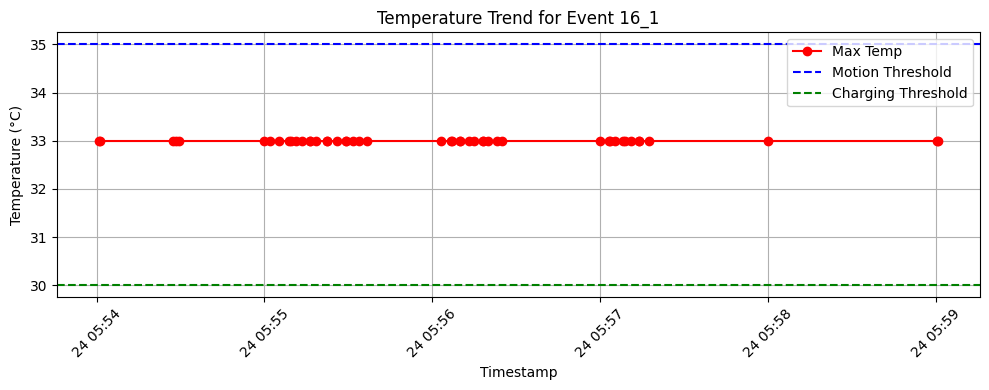

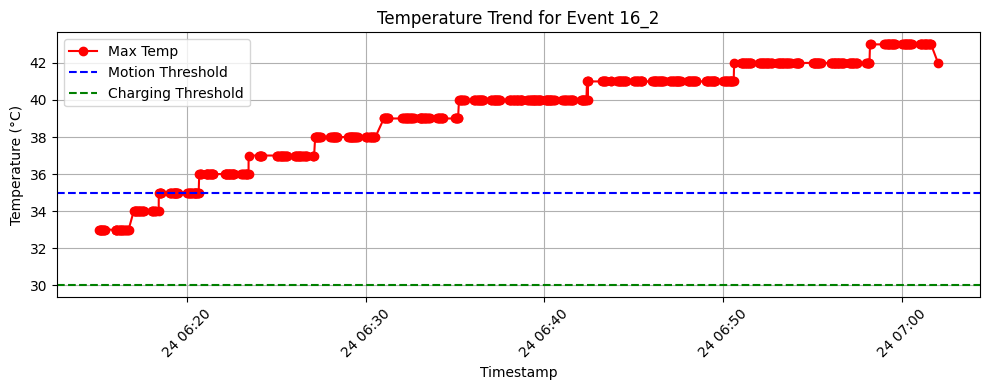

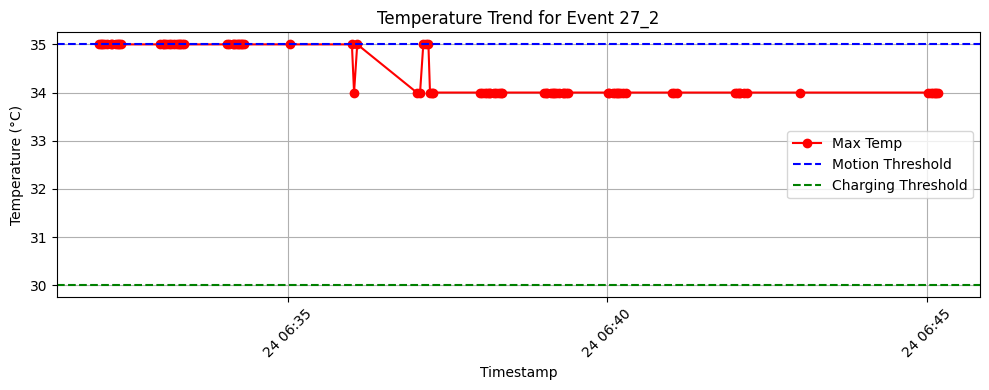

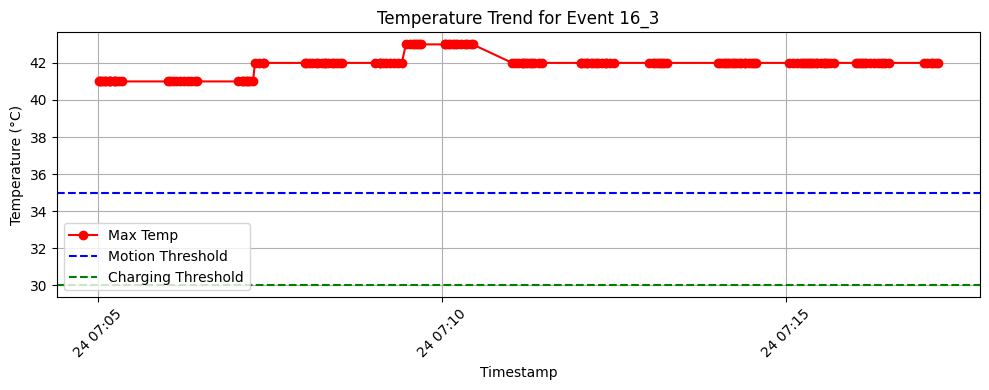

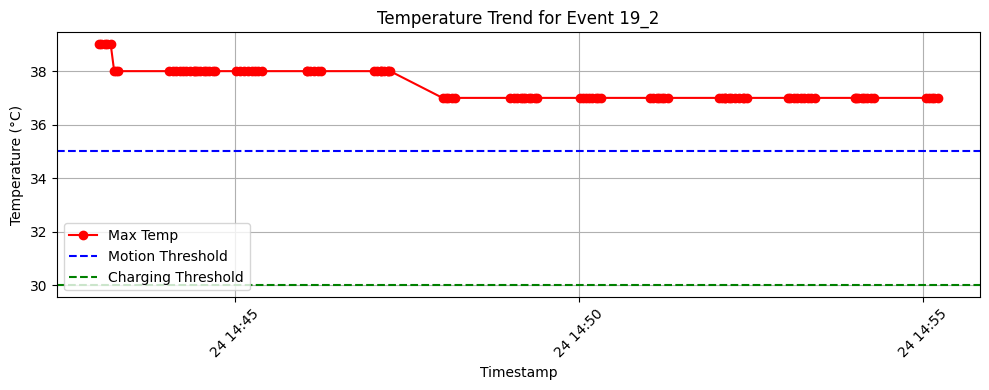

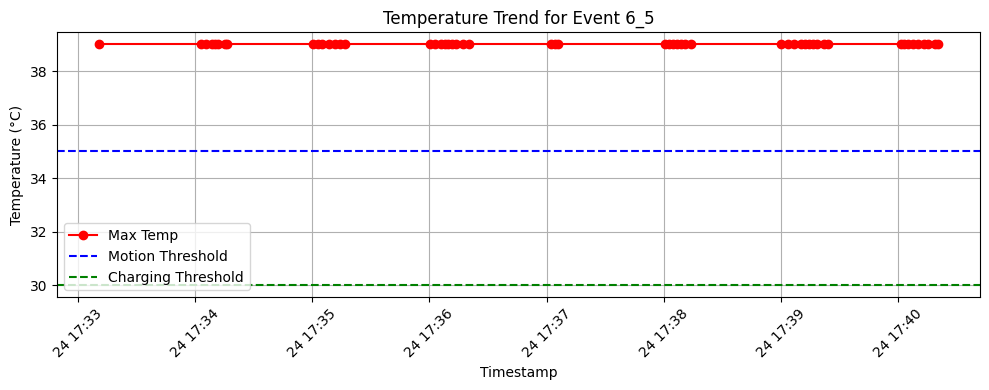

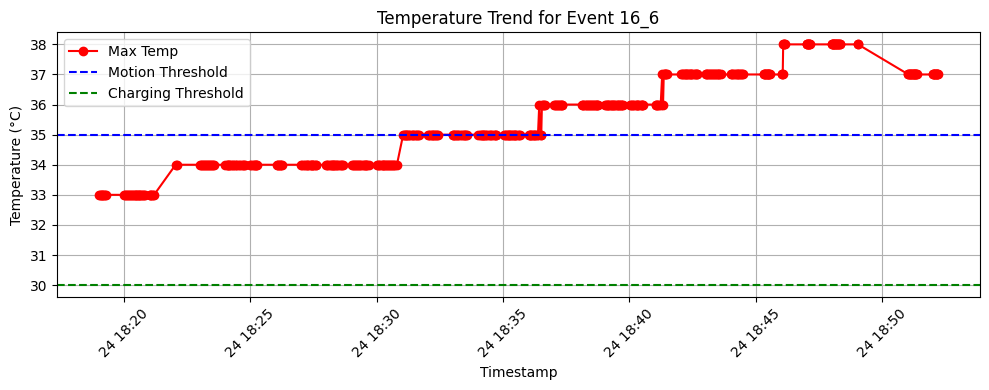

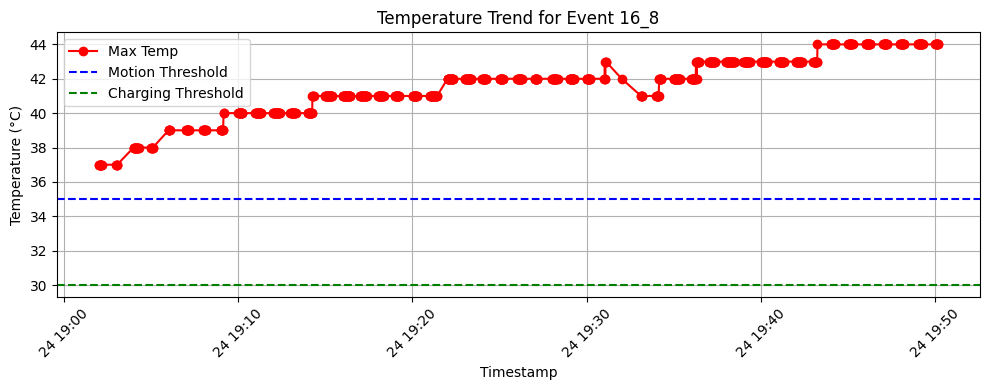

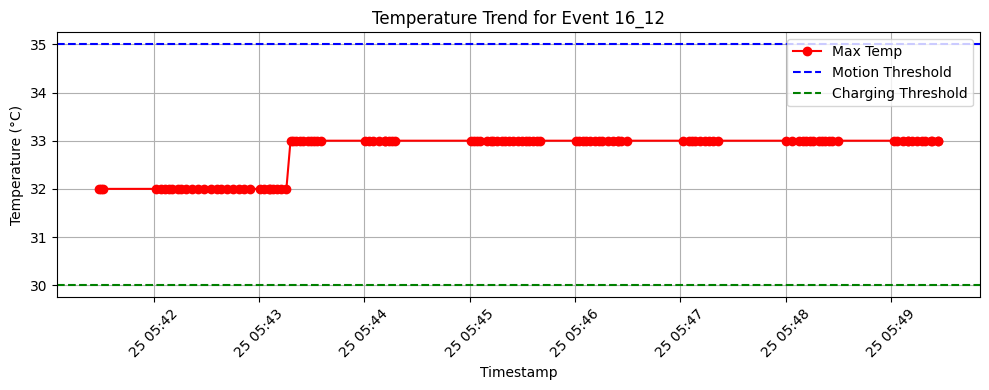

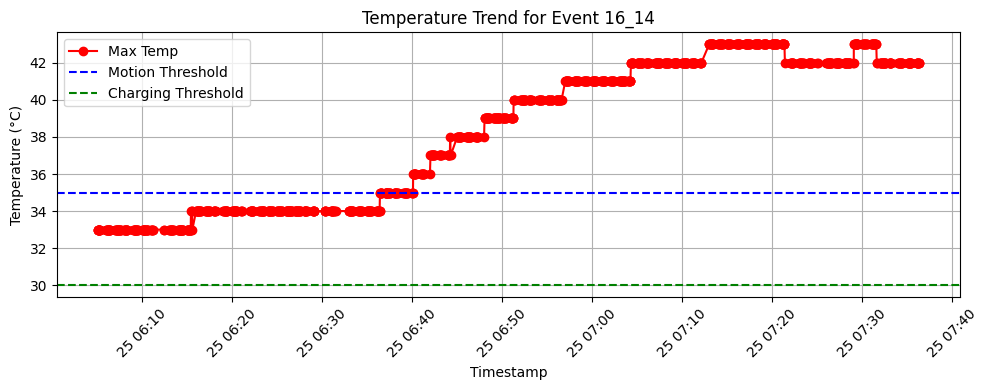

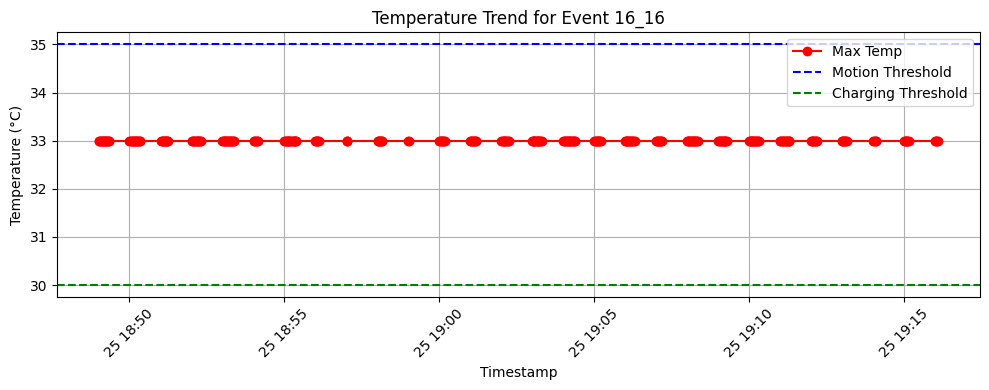

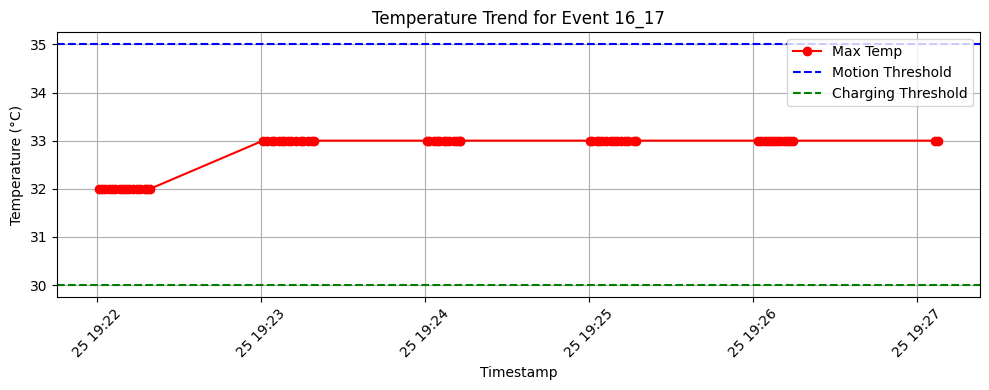

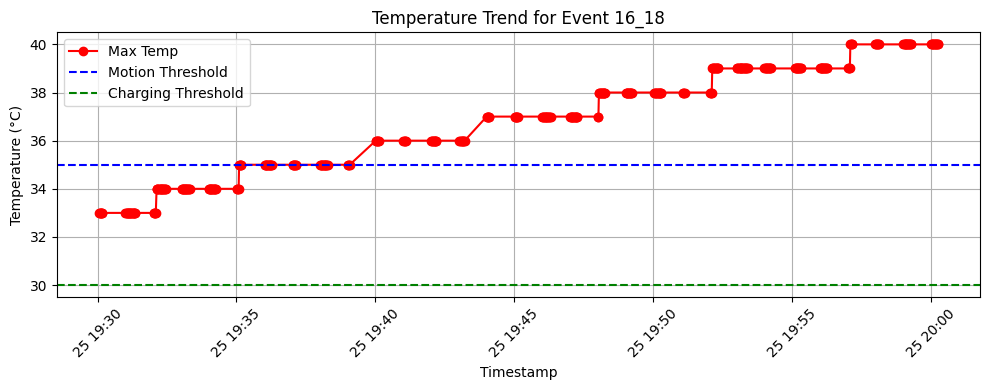

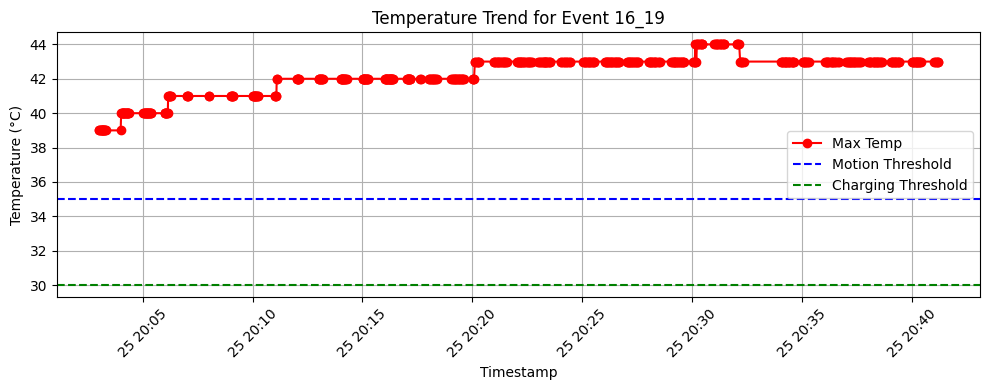

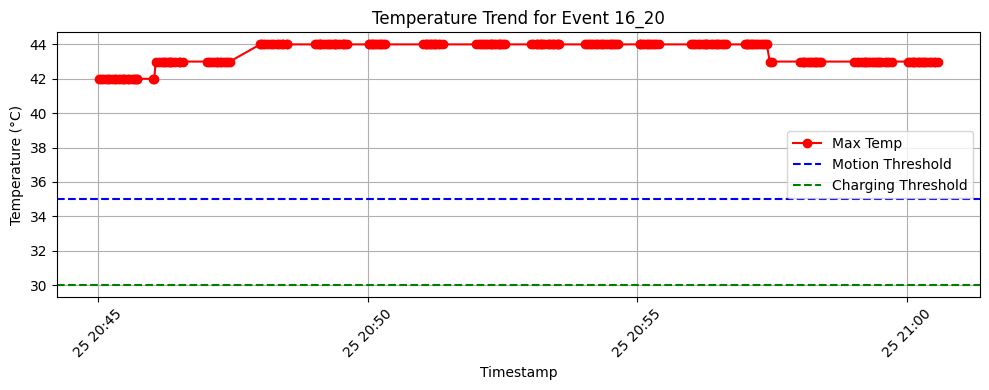

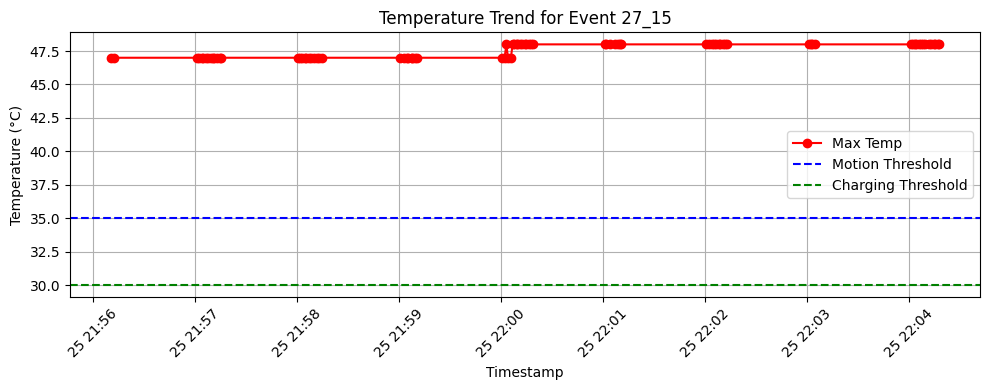

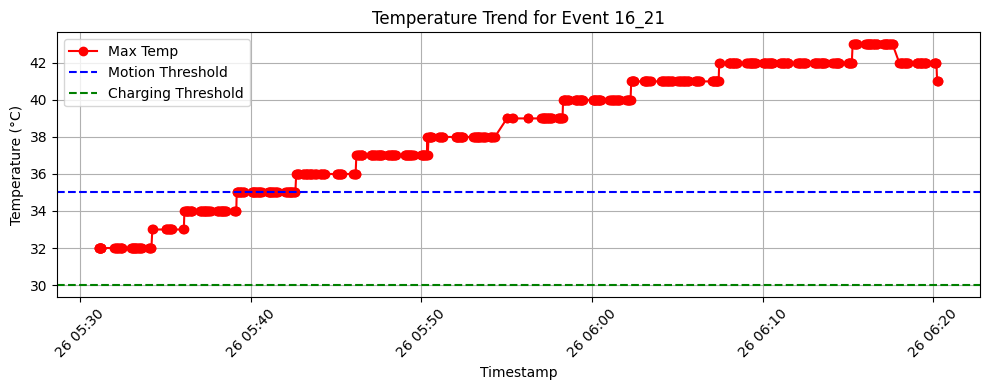

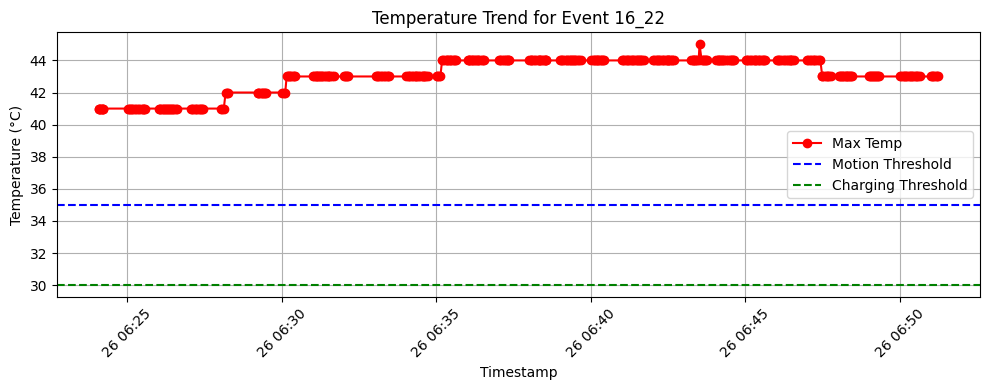

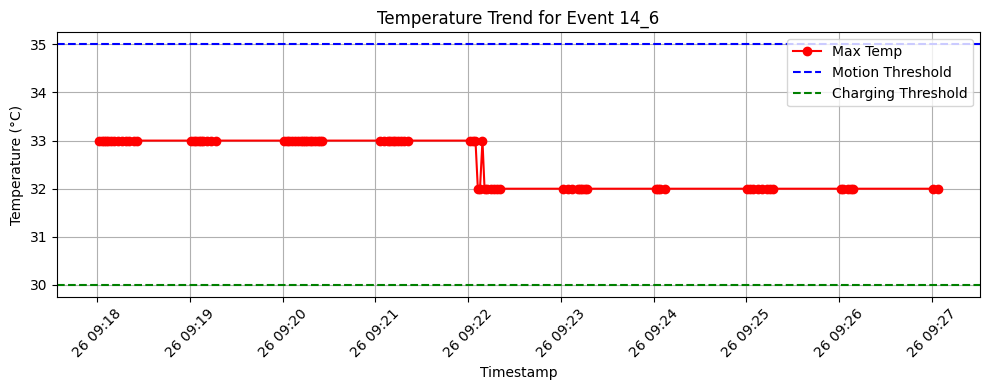

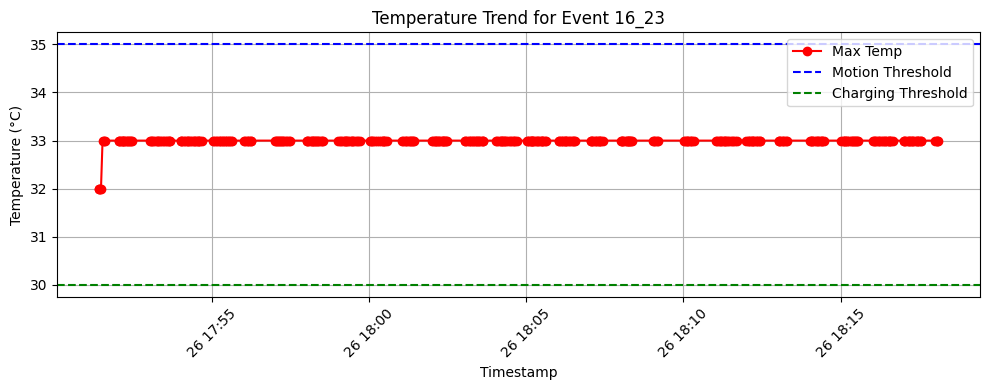

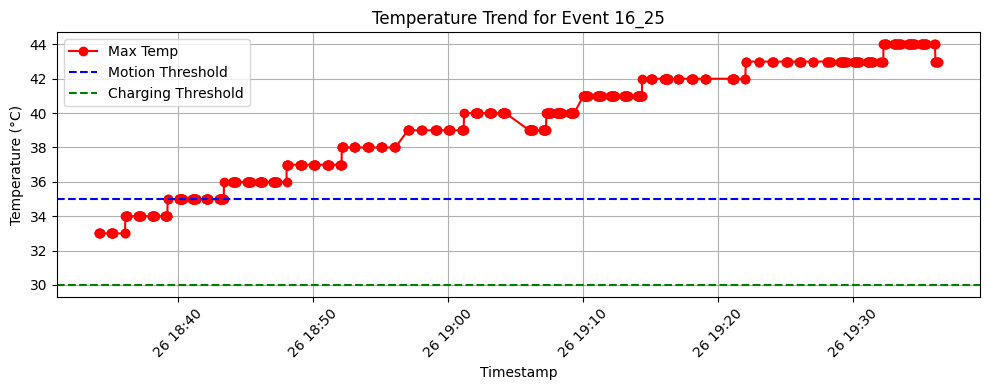

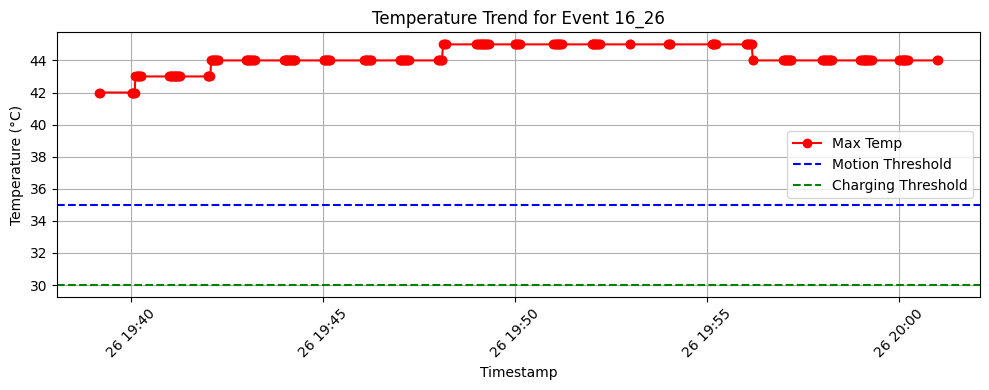

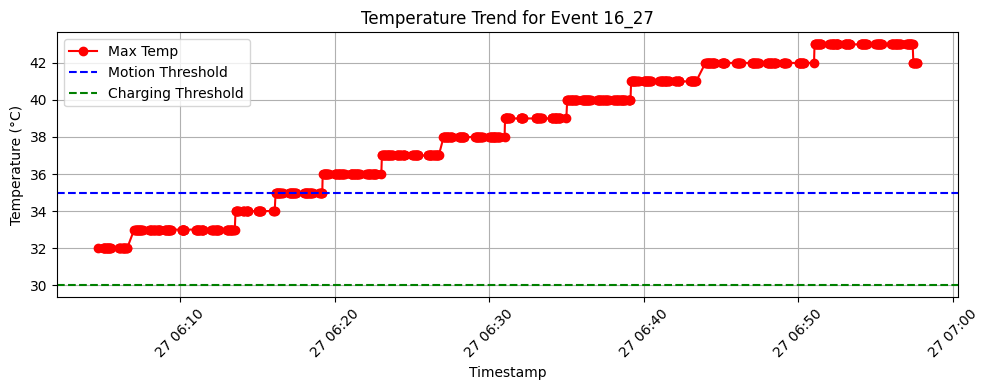

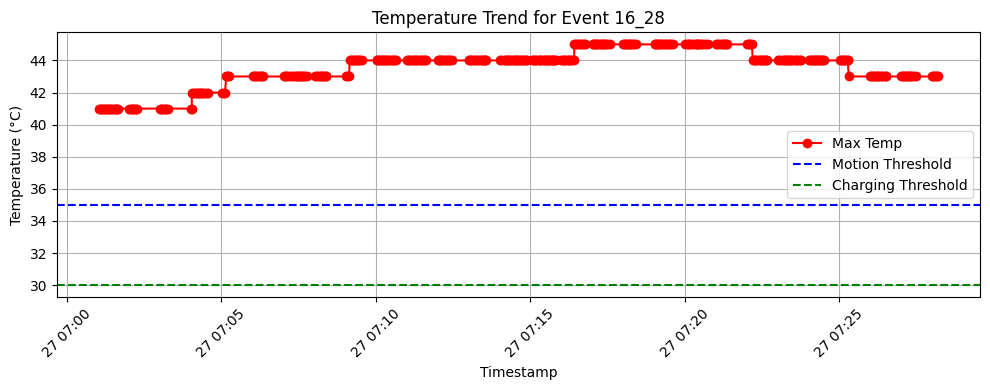

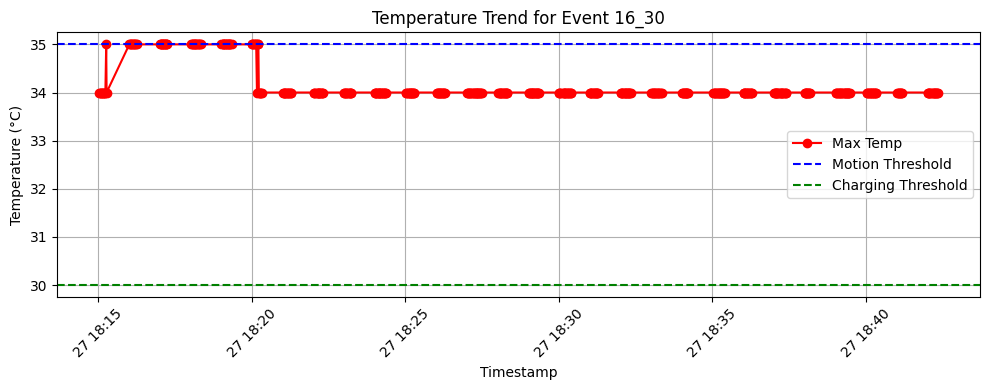

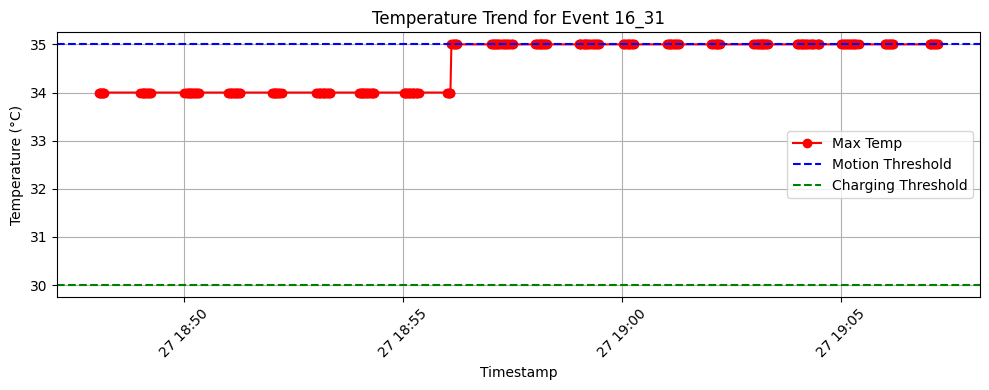

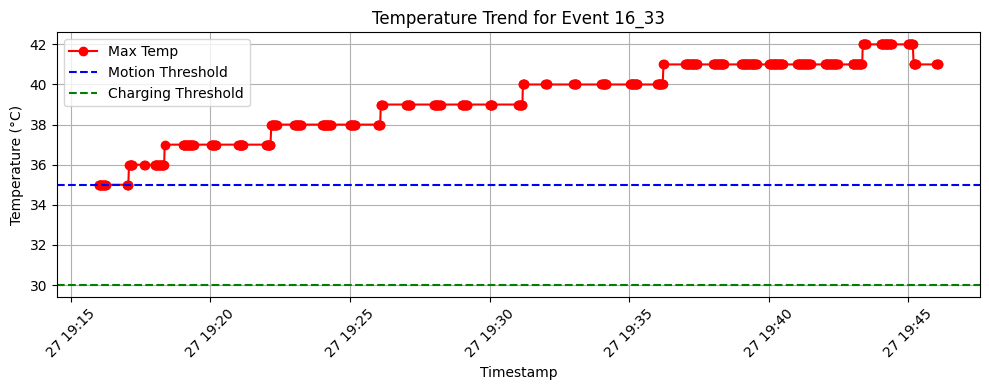

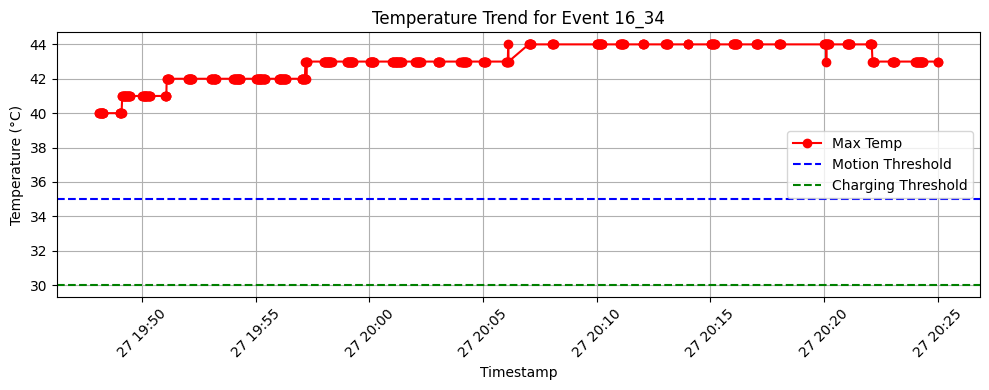

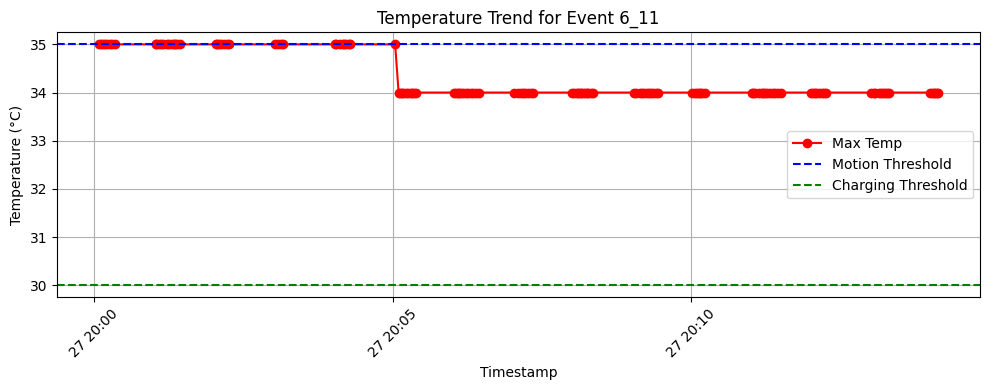

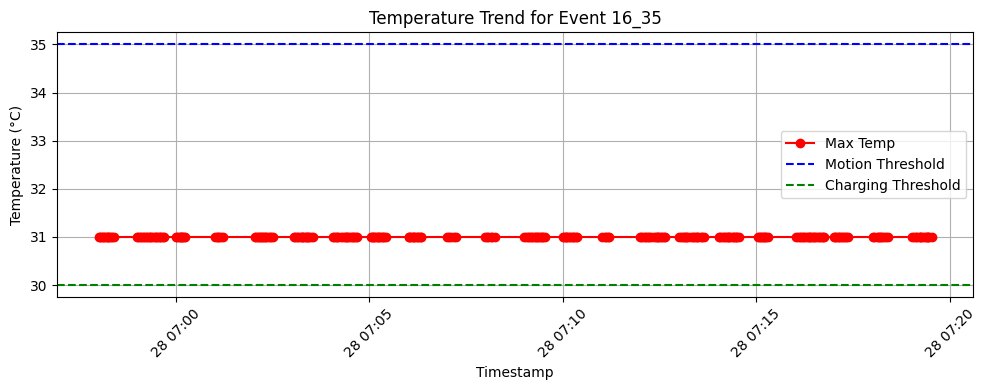

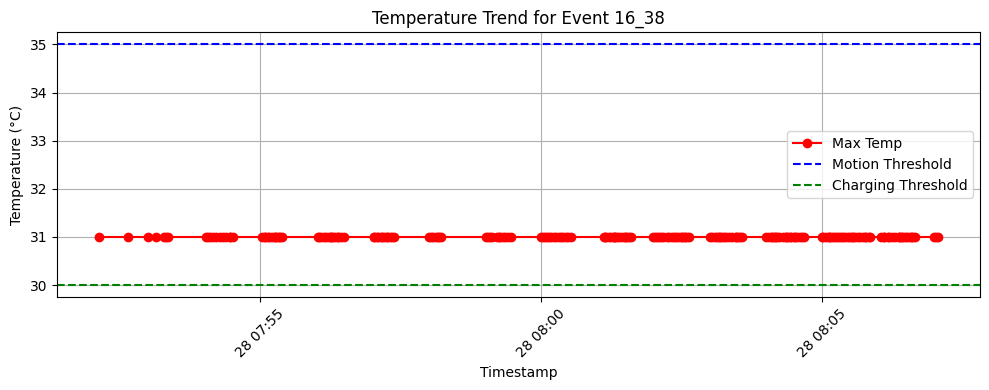

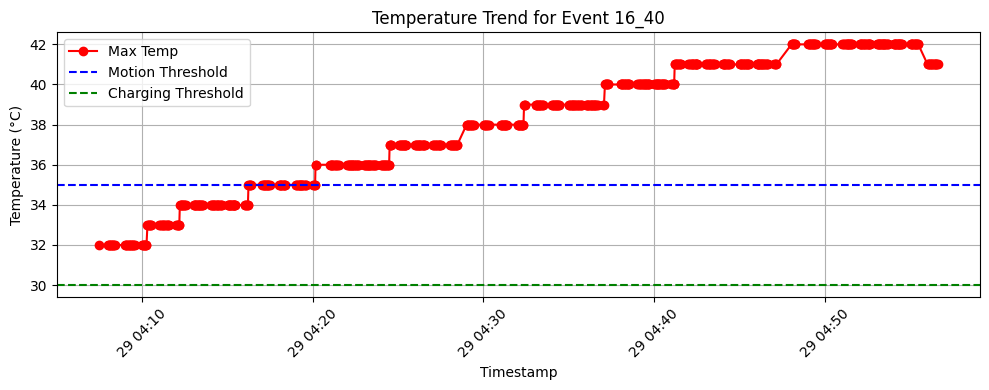

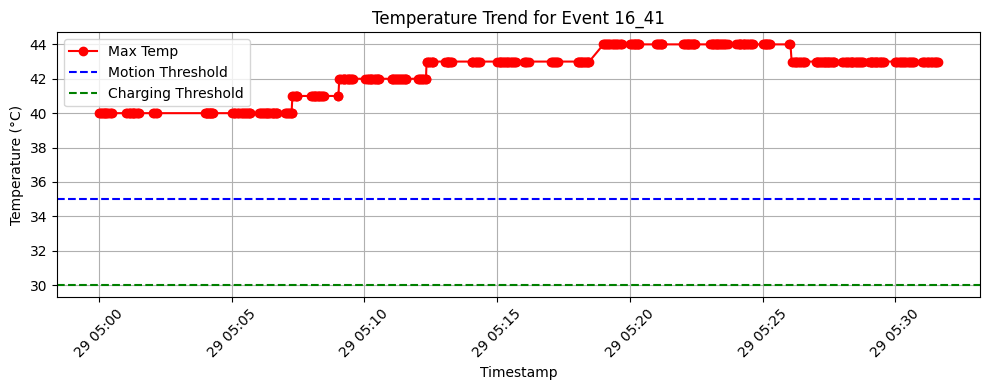

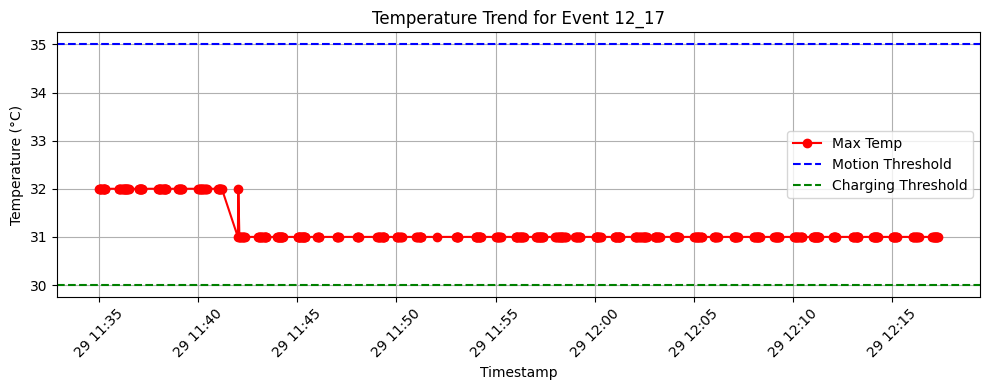

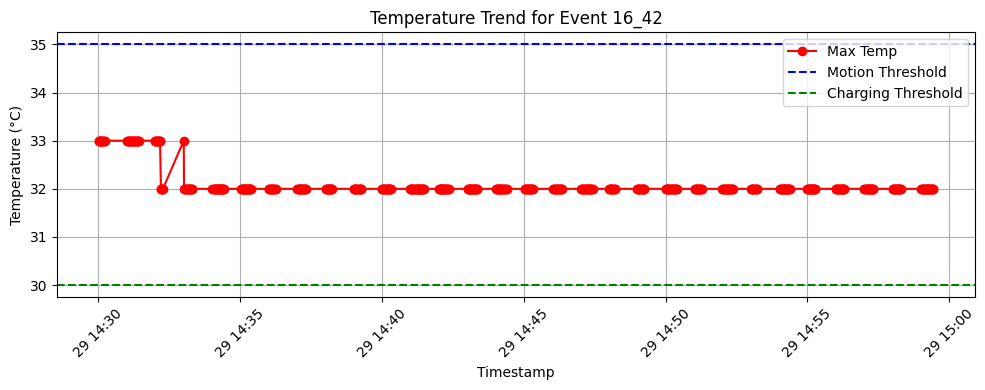

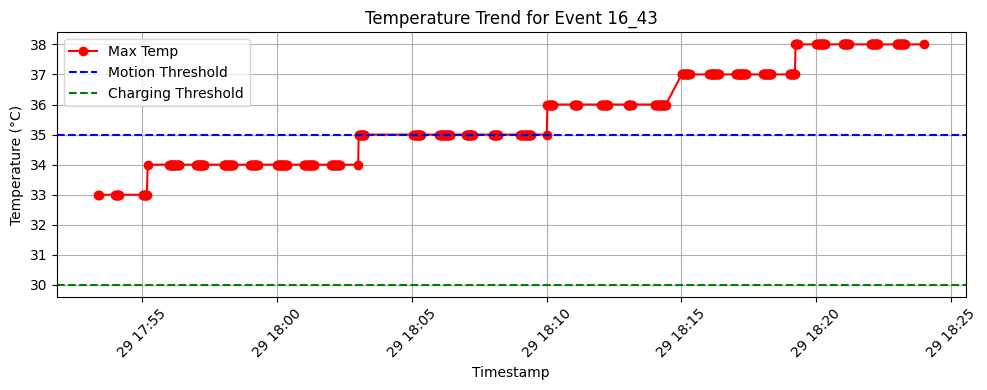

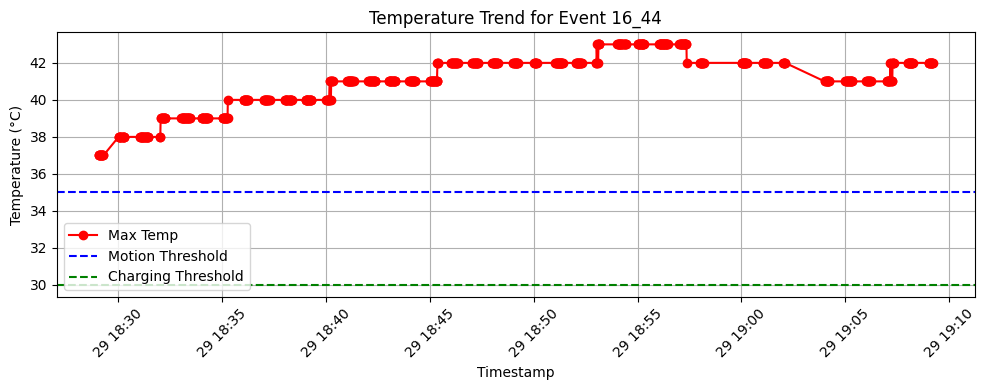

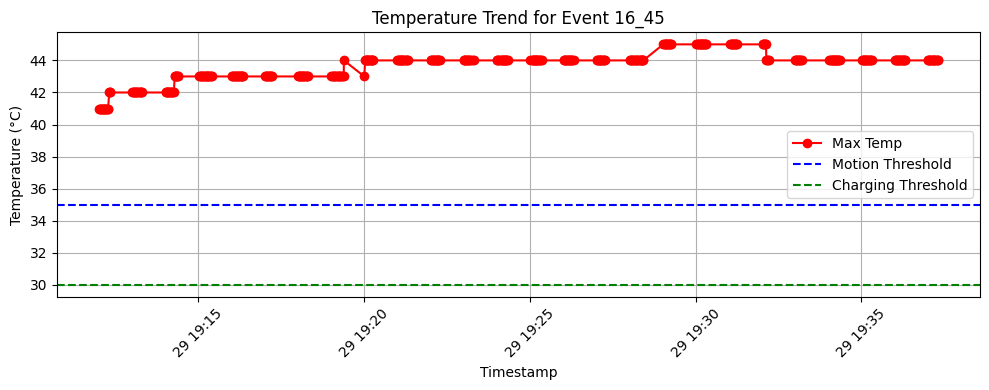

In [11]:
# Assuming you have your data in a DataFrame called 'df'
# Analyze the entire dataset
alert_events,event_summaries = run_analysis(df)

# Analyze a specific time period
# start_time = '2025-10-10 11:55:00'
# end_time = '2025-10-10 12:25:00'
# alert_events = run_analysis(df,start_time, end_time)

In [12]:
event_summaries

,event_id,event_start_time,event_end_time,event_duration_sec,event_max_temp,event_min_temp,event_avg_temp,event_type,id,tms_working_mode,event_duration
0,12_17,2025-09-29 11:35:00.760000+05:30,2025-09-29 12:17:17.960000+05:30,2537.200,32,26,31.183133,charging,12,Off,42 min 17 sec
1,14_6,2025-09-26 09:18:01.124000+05:30,2025-09-26 09:27:04.085000+05:30,542.961,33,28,32.597701,charging,14,Off,9 min 2 sec
2,16_1,2025-09-24 05:54:00.799000+05:30,2025-09-24 05:59:00.879000+05:30,300.080,33,29,33.000000,charging,16,Off,5 min 0 sec
3,16_12,2025-09-25 05:41:28.769000+05:30,2025-09-25 05:49:26.809000+05:30,478.040,33,27,32.743590,charging,16,Off,7 min 58 sec
4,16_14,2025-09-25 06:05:07.869000+05:30,2025-09-25 07:36:20.589000+05:30,5472.720,43,28,38.360709,charging,16,Off,91 min 12 sec
5,16_16,2025-09-25 18:49:01.085000+05:30,2025-09-25 19:16:06.665000+05:30,1625.580,33,29,33.000000,charging,16,Off,27 min 5 sec
6,16_17,2025-09-25 19:22:00.575000+05:30,2025-09-25 19:27:07.586000+05:30,307.011,33,29,32.774648,charging,16,Off,5 min 7 sec
7,16_18,2025-09-25 19:30:02.685000+05:30,2025-09-25 20:00:15.605000+05:30,1812.920,40,29,36.750000,charging,16,Off,30 min 12 sec
8,16_19,2025-09-25 20:03:00.526000+05:30,2025-09-25 20:41:11.049000+05:30,2290.523,44,34,42.302372,charging,16,Off,38 min 10 sec
9,16_2,2025-09-24 06:15:03.960000+05:30,2025-09-24 07:02:01.684000+05:30,2817.724,43,29,39.318697,charging,16,Off,46 min 57 sec
